<a href="https://colab.research.google.com/github/aewallwi/calamity/blob/main/examples/Calamity_Example_Garray_15_Elements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Aug  6 06:05:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install git+https://github.com/aewallwi/calamity.git

  Cloning https://github.com/aewallwi/calamity.git to /tmp/pip-req-build-5w3l6d_i
  Running command git clone -q https://github.com/aewallwi/calamity.git /tmp/pip-req-build-5w3l6d_i
  Cloning git://github.com/HERA-Team/uvtools to /tmp/pip-install-97pgzrjs/uvtools_dc02c8e1f69f473abf43c828cbed9122
  Running command git clone -q git://github.com/HERA-Team/uvtools /tmp/pip-install-97pgzrjs/uvtools_dc02c8e1f69f473abf43c828cbed9122


In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from calamity import cal_utils
from calamity import calamity
import numpy as np
from uvtools import dspec
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import copy

In [4]:


def delay_transform_sort_by_baseline_length(uvd, tind=0, polind=0, window='bh', min_bl=0.1, fold=True):
    """
    generate an (NF x NBL) array with baselines arranged in ascending length

    Parameters
    ----------
    uvd: UVData object
        UVData with data that you want to inspect FFT of.
    polind: int, optional
        index of polarization to return.
        default is 0.
    window: str, optional
        fourier transform window function.
        default is blackman harris.
    min_bl: float, optional
        minimum baseline length to include
        default is 0.1 (meters)

    Returns
    -------
    bl_lens: array-like
        Nbls float array with lengths of each baseline.
    delays: array-like
        Nfreqs float array of delays for each baseline.
    fftd_data: array-like
        Nbls x Nfreqs array of data that has been Fourier transformed along the
        frequency axis. Baselines are arranged along baseline axis in ascending length.
    """
    data_inds = np.where(uvd.time_array == np.unique(uvd.time_array)[tind])[0]
    data = uvd.data_array[data_inds, 0, :, polind].reshape(len(data_inds), uvd.Nfreqs)
    bl_lens = np.linalg.norm(uvd.uvw_array[data_inds], axis=1)
    sorted_lens = np.argsort(bl_lens)
    data = data[sorted_lens, :]
    bl_lens = bl_lens[sorted_lens]
    data = data[bl_lens > min_bl]
    bl_lens = bl_lens[bl_lens > min_bl]
    wf = dspec.gen_window(window, uvd.Nfreqs)
    df = np.mean(np.diff(uvd.freq_array))
    delays = 1e9 * np.fft.fftshift(np.fft.fftfreq(uvd.Nfreqs, df))
    fftd_data =  np.fft.fftshift(np.fft.fft(np.fft.fftshift(wf[None, :] * data, axes=1), axis=1), axes=1) * df
    if fold:
      fftd_data = .5 * (fftd_data[:, uvd.Nfreqs//2:] + fftd_data[:, :uvd.Nfreqs//2][:, ::-1])
      delays = delays[uvd.Nfreqs//2:]
    return bl_lens, delays, fftd_data


In [5]:
from calamity.data import DATA_PATH
import glob
import os
from pyuvdata import UVData
uvd_fg = UVData()
uvd_fg.read_uvh5(glob.glob(os.path.join(DATA_PATH, '*nant15*gleam*.uvh5'))[0])
uvd_eor = UVData()
uvd_eor.read_uvh5(glob.glob(os.path.join(DATA_PATH, '*nant15*eor*.uvh5'))[0])
uvd_eor.data_array *= 1
uvd_total = copy.deepcopy(uvd_eor)
uvd_total.data_array += uvd_fg.data_array

In [6]:
# generate uncalibrated data.
uvd_uncalib = copy.deepcopy(uvd_total)
# generate gains
gains = cal_utils.blank_uvcal_from_uvdata(uvd_uncalib)
gains.gain_array = gains.gain_array + 1e-1 * np.random.randn(*gains.gain_array.shape) + 1e-1j * np.random.randn(*gains.gain_array.shape)
# apply gains
uvd_uncalib = cal_utils.apply_gains(uvd_uncalib, gains, inverse=True)

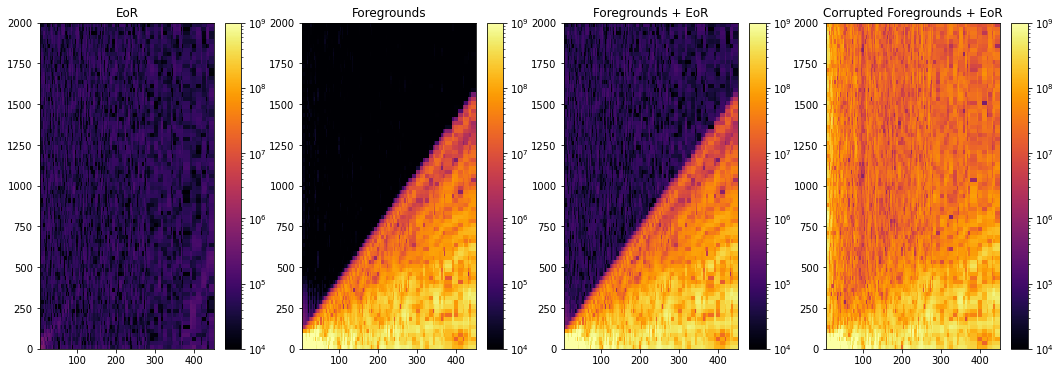

In [7]:
fig, axarr = plt.subplots(1, 4)
fig.set_size_inches(18, 6)
for uvdt, ax, label in zip([uvd_eor, uvd_fg, uvd_total, uvd_uncalib], axarr, ['EoR',  'Foregrounds', 'Foregrounds + EoR', 'Corrupted Foregrounds + EoR']):
  bl, dly, wedge = delay_transform_sort_by_baseline_length(uvdt)
  blg, dlyg = np.meshgrid(bl, dly)
  plt.sca(ax)
  plt.pcolor(blg, dlyg, np.abs(wedge).T, norm=LogNorm(1e4, 1e9), cmap='inferno')
  plt.title(label)
  plt.ylim(0, 2000)
  plt.colorbar()

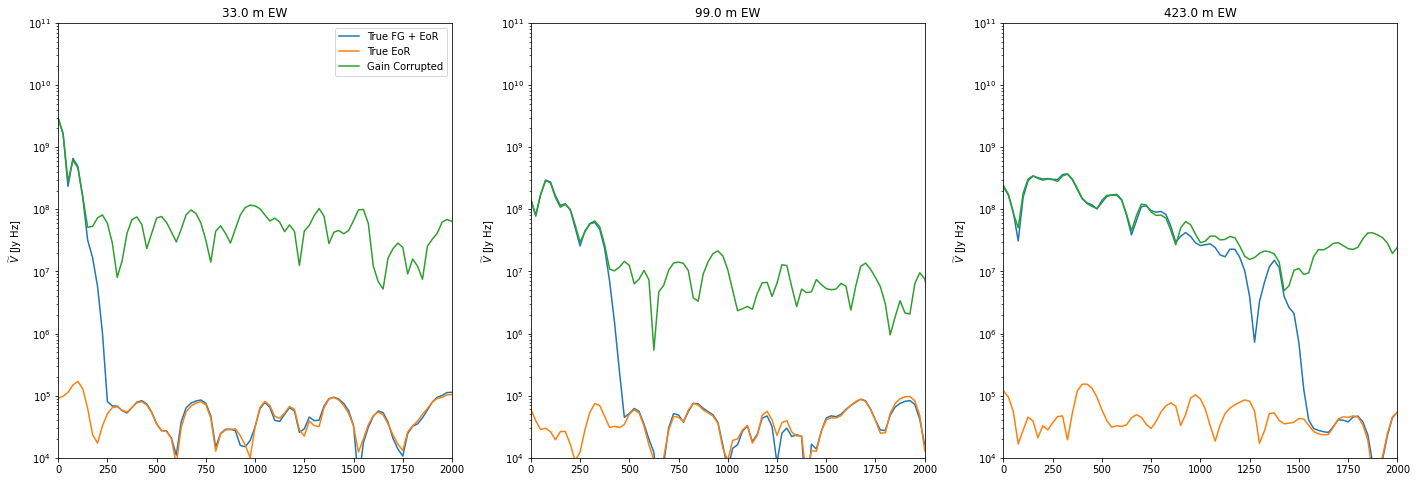

In [8]:
blinds = [10, 30, 100]
fig, axarr = plt.subplots(1, len(blinds))
fig.set_size_inches(24, 8)
labels = ['True FG + EoR', 'True EoR', 'Gain Corrupted']
for blnum, blind in enumerate(blinds):
    plt.sca(axarr[blnum])
    for i, uvt in enumerate([uvd_total,  uvd_eor, uvd_uncalib]):
        x, y, ctot = delay_transform_sort_by_baseline_length(uvt, window='bh7')
        plt.plot(y, np.abs(ctot[blind]), label=labels[i])
        plt.xlim(0, 2000)
        plt.ylim(1e4, 1e11)
        plt.yscale('log')
    plt.title('%.1f m EW'%x[blind])
    if blnum == 0:
      plt.legend()
    plt.ylabel('$\\tau$ [ns]')
    plt.ylabel('$\\widetilde{V}$ [Jy Hz]')

In [9]:
gains_0 = cal_utils.blank_uvcal_from_uvdata(uvd_uncalib)
model_fit, resid_fit, gains_fit, fitting_info = calamity.calibrate_and_model_dpss(min_dly=2./.3, offset=2./.3, 
                                                                                uvdata=uvd_uncalib, sky_model=uvd_uncalib, freeze_model=False, 
                                                                                gains=gains_0, notebook_progressbar=True, correct_resid=True, correct_model=True,
                                                                                learning_rate=1e-2, verbose=True,
                                                                                use_redundancy=False)


2021-08-06 06:05:29.075217 Computing foreground components matrices...

2021-08-06 06:05:29.645031Finished Converting Foreground Modeling Components to Tensors...

2021-08-06 06:05:29.645300 Working on pol xx, 1 of 1...

2021-08-06 06:05:29.645842 Working on time 1 of 1...

2021-08-06 06:05:29.645912 Tensorizing data...

2021-08-06 06:05:29.693263 Tensorizing Gains...

2021-08-06 06:05:29.693862 Tensorizing Foreground coeffs...

2021-08-06 06:05:29.693920 Computing initial foreground coefficient guesses using linear-leastsq...




2021-08-06 06:05:30.504023 Finished initial foreground coefficient guesses...

2021-08-06 06:05:30.504092 Computing initial foreground coefficient guesses using linear-leastsq...




2021-08-06 06:05:30.859163 Finished initial foreground coefficient guesses...

2021-08-06 06:05:30.876594 Performing gradient descent on 3000 complex gain parameters...
Performing gradient descent on total of 13965 complex foreground parameters
Foreground Parameters grouped into chunks of shape ((nvecs, ngrps): nbls) ['(133, 105):1']
2021-08-06 06:05:30.877066 Building Computational Graph...

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
2021-08-06 06:05:31.623509 Performing Gradient Descent. Initial MSE of 3.82e-02...




2021-08-06 06:06:10.271869 Finished Gradient Descent. MSE of 6.79e-08...



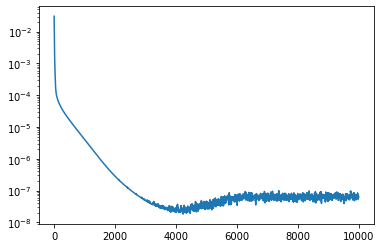

In [10]:
plt.plot(np.abs(fitting_info[0][0]['loss']))
plt.yscale('log')

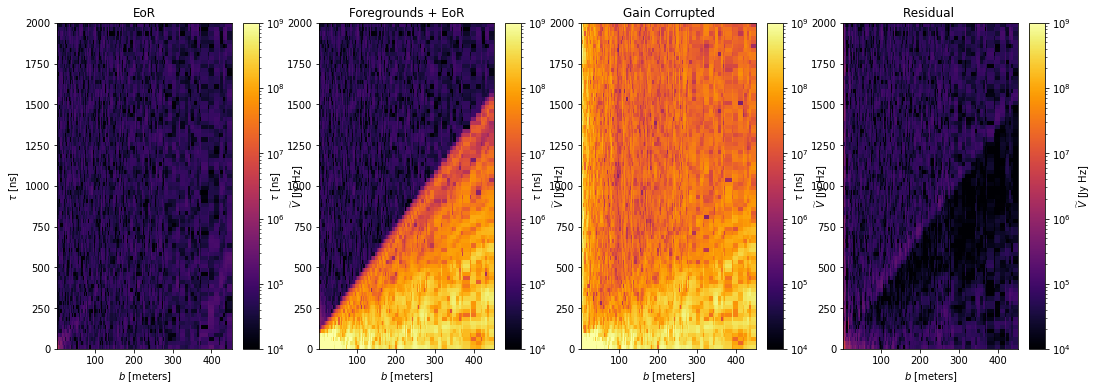

In [11]:
fig, axarr = plt.subplots(1, 4)
fig.set_size_inches(18, 6)
for uvdt, ax, label in zip([uvd_eor, uvd_total, uvd_uncalib, resid_fit], axarr, ['EoR', 'Foregrounds + EoR', 'Gain Corrupted', 'Residual ']):
  bl, dly, wedge = delay_transform_sort_by_baseline_length(uvdt)
  blg, dlyg = np.meshgrid(bl, dly)
  plt.sca(ax)
  plt.pcolor(blg, dlyg, np.abs(wedge).T, norm=LogNorm(1e4, 1e9), cmap='inferno')
  plt.title(label)
  plt.ylim(0, 2000)
  plt.colorbar(label='$\\widetilde{V}$ [Jy Hz]')
  plt.ylabel('$\\tau$ [ns]')
  plt.xlabel('$b$ [meters]')

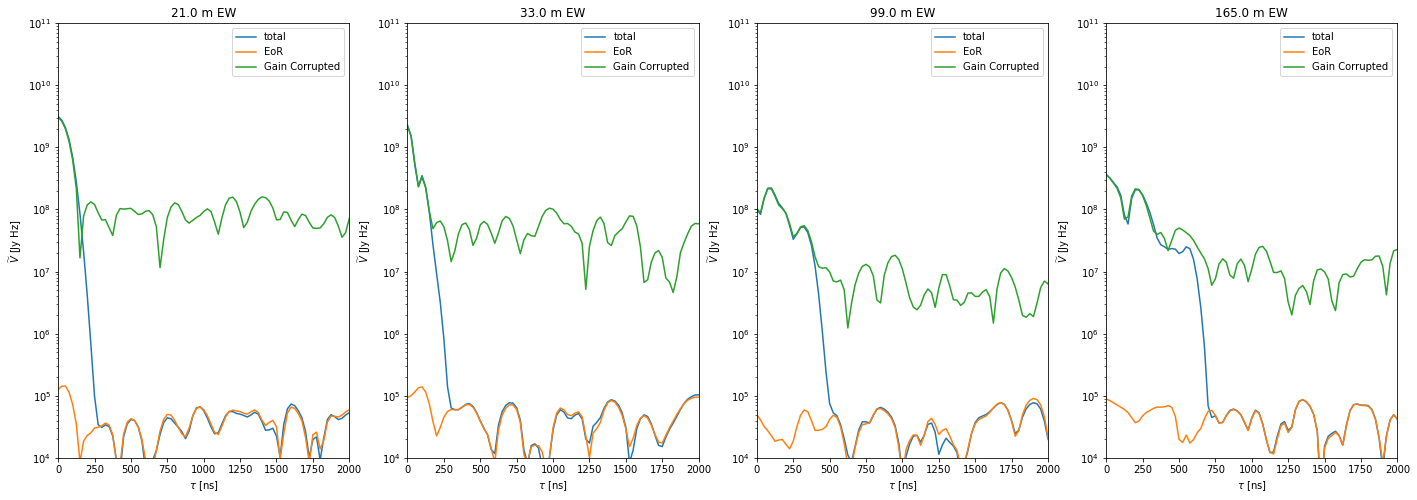

In [12]:
blinds = [6, 10, 30, 50]
fig, axarr = plt.subplots(1, len(blinds))
fig.set_size_inches(24, 8)
for blnum, blind in enumerate(blinds):
    plt.sca(axarr[blnum])
    
    for i, uvt, label in zip(range(3), [uvd_total, uvd_eor,  uvd_uncalib, resid_fit], 
                             ['total', 'EoR', 'Gain Corrupted', 'Resid']):
        x, y, ctot = delay_transform_sort_by_baseline_length(uvt, window='cs11')
        plt.plot(y, np.abs(ctot[blind]), label=label)
        plt.xlim(0, 2000)
        plt.ylim(1e4, 1e11)
        plt.yscale('log')
    plt.title('%.1f m EW'%x[blind])
    plt.legend()
    plt.xlabel('$\\tau$ [ns]')
    plt.ylabel('$\\widetilde{V}$ [Jy Hz]')